# Курсовой проект по курсу "Алгоритмы анализа данных"

#### Задание:
предсказать средний балл на экзамене по математике, который получают ученики репетиторов из датасета test.csv. 

#### Целевая переменная: 
mean_exam_points

#### Метрика качества:
R2 - коэффициент детерминации

$$R^2 = 1 - \frac{\sigma^2}{\sigma_y^2} = 1 - \frac{\Sigma_{i=1}^{n}(y_i -{z_i})^2}{\Sigma_{i=1}^{n}(y_i - \overline{y})^2},$$

где $y_i$ -- фактические значения целевой переменной, \
$z_i$ -- рассчетные значения целевой переменной, \
$\overline{y} = \frac{1}{n}\Sigma_{i=1}^{n}y_i$ -- среднее значение целевой переменной.

#### Ссылка на kaggle:
https://www.kaggle.com/c/tutors-expected-math-exam-results

## <center>Используемые библиотеки, директории и функции<center>

**Подключение библиотек и скриптов**

In [909]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns 

**Пути к директориям и файлам**

In [910]:
DATASET_PATH_TRAIN = './train.csv'
DATASET_PATH_TEST = './test.csv'

**Пользовательские функции**

In [911]:
#функция приведения типов
def type_conversion(data_set):
    for feauture in ['Id', 'qualification', 'physics', 'chemistry', 'biology', 'english', 'geography', 'history']:
        data_set[feauture] = data_set[feauture].astype('category')
    return data_set

In [912]:
#функция проверки правила трех сигм
def three_sigma_rule(data_set, features):
    for feature in features:
        if (data_set[feature].min() > data_set[feature].mean() - 3*data_set[feature].std(ddof = 1)) & (data_set[feature].max() < data_set[feature].mean() + 3*data_set[feature].std(ddof = 1)):
            print(f'Для признака {feature} выполняется правило трех сигм \n')
        else:
            print(f'Для признака {feature} не выполняется правило трех сигм \n')

In [913]:
#функция поиска выбросов
def finding_outliers(data_set, features):
    for feature in features:
        plt.figure(figsize=(6, 3))
        sns.boxplot(data_set[feature], whis=1.5)
        plt.xlabel(feature)
        plt.show()

In [914]:
#функция анализа категориальных признаков
def cat_features_analysis(data_set, features):
    for feature in features:
        print(str(feature) + '\n\n' + str(data_set[feature].value_counts()) + '\n' + '*' * 80 + '\n')
        counts = data_set[feature].value_counts()
        plt.figure(figsize=(6,6))    
        plt.title(feature)
        sns.barplot(counts.index, counts.values)
        plt.show()

In [915]:
#функция построения новых признаков для тестового датасета
def new_features_for_test(data_set):
    #бинарные признаки
    for feature in ['physics', 'chemistry', 'biology', 'english', 'geography', 'history']:
        data_set[feature] = data_set[feature].astype(int)
    #dummies
    data_set = pd.concat([data_set, pd.get_dummies(data_set["qualification"], prefix="qualification")], axis=1)
    #добавляем признак с числом преподаваемых предметов
    data_set['num_of_subjects'] = data_set[['physics', 'chemistry', 'biology', 'english', 'geography', 'history']].sum(axis = 1)
    #добавляем признак мультипредметность преподавателя
    data_set['multi_subjects_tutor'] = np.where(data_set['num_of_subjects'] >=3, 1, 0)
    #определяем преподавателя, который специализируется только на физике
    data_set['only_physics_tutor'] = np.where((data_set['physics'] == 1) & (data_set['chemistry'] == 0) & (data_set['biology'] == 0) & (data_set['english'] == 0) & (data_set['geography'] == 0) & (data_set['history'] == 0), 1, 0)
    #добавляем признак опытного преподавателя
    data_set['experienced_tutor'] = np.where(data_set['years_of_experience'] >=5, 1, 0)
    #добавим признак высоко квалифицированного преподавателя
    data_set['hight_qualification'] = np.where((data_set['qualification'] == 3) | (data_set['qualification'] == 4), 1, 0)
    #добавляем признаки оценки стоимости урока
    data_set['expensive_lesson'] = np.where(data_set['lesson_price'] >= 2000 , 1, 0)
    data_set['cheap_lesson'] = np.where(data_set['lesson_price'] <= 1500, 1, 0)
    #добавляем признак оценки возраста преподавателя
    data_set['young_tutor'] = np.where(data_set['age'] <= 45, 1, 0)
    return data_set

In [916]:
# функция вычисления коэффициента детерминации
def r2_score(y,y_pred):
    d1 = y - y_pred
    d2 = y - y.mean()
    r2 = 1 - d1.dot(d1) / d2.dot(d2)
    return r2

In [917]:
# функция оценки качества модели и график preds vs true
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
   
    print("Train R2:\t" + str(round(r2_score(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2_score(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

## <center>ПЛАН РЕШЕНИЯ<center>

[**Глава 1.** Разведочный анализ данных](#part1)\
[$\S1.1$. Загрузка датасетов train и test](#par1.1) \
[$\S1.2$. Приведение типов](#par1.2) \
[$\S1.3$. Распределение целевой переменной](#par1.3) \
[$\S1.4$. Анализ количественных признаков](#par1.4) \
[$\S1.5$. Обработка выбросов в количественных признаках](#par1.5) \
[$\S1.6$. Анализ категориальных признаков](#par1.6)\
[$\S1.7$. Корреляционный анализ](#par1.7)\
[$\S1.8$. Построение новых признаков](#par1.8)

[**Глава 2.** Построение модели регрессии](#part2)\
[$\S2.1$. Отбор признаков](#par2.1)\
[$\S2.2$. Реализация алгоритма модели](#par2.2)\
[$\S2.3$. Построение модели](#par2.3)

[**Глава 3.** Прогнозирование на датасете test](#part3)\
[$\S3.1$. Предсказание значений целевой переменной с помощью итоговой модели](#par3.1) \
[$\S3.2$. Создание и сохранение датасета с прогнозами целевой переменной](#par3.2)

## <center>Глава 1. Разведочный анализ данных<a class="anchor" id="part1"></a><center>

### $\S 1.1.$ Загрузка даннных<a class="anchor" id="par1.1">

In [919]:
# Загружаем тренировочный датасет
df_train = pd.read_csv(DATASET_PATH_TRAIN)
df_train.head()

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points
0,0,40.0,0.0,1400.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,63.0
1,1,48.0,4.0,2850.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,86.0
2,2,39.0,0.0,1200.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0
3,3,46.0,5.0,1400.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,56.0
4,4,43.0,1.0,1500.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,59.0


In [920]:
# Общее количество записей 10000, для каждой 12 признаков
df_train.shape

(10000, 12)

In [921]:
# Пропуски в данных отсутствуют
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Id                   10000 non-null  int64  
 1   age                  10000 non-null  float64
 2   years_of_experience  10000 non-null  float64
 3   lesson_price         10000 non-null  float64
 4   qualification        10000 non-null  float64
 5   physics              10000 non-null  float64
 6   chemistry            10000 non-null  float64
 7   biology              10000 non-null  float64
 8   english              10000 non-null  float64
 9   geography            10000 non-null  float64
 10  history              10000 non-null  float64
 11  mean_exam_points     10000 non-null  float64
dtypes: float64(11), int64(1)
memory usage: 937.6 KB


In [922]:
# Заружаем и просматриваем тестовый датасет
df_test = pd.read_csv(DATASET_PATH_TEST)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Id                   10000 non-null  int64  
 1   age                  10000 non-null  float64
 2   years_of_experience  10000 non-null  float64
 3   lesson_price         10000 non-null  float64
 4   qualification        10000 non-null  float64
 5   physics              10000 non-null  float64
 6   chemistry            10000 non-null  float64
 7   biology              10000 non-null  float64
 8   english              10000 non-null  float64
 9   geography            10000 non-null  float64
 10  history              10000 non-null  float64
dtypes: float64(10), int64(1)
memory usage: 859.5 KB


**Вывод:** тренировочный и тестовый датасеты имеют одинаковые размеры, пропуски в данных отсутствуют.

### $\S 1.2.$ Приведение типов <a class="anchor" id="par1.2">

In [923]:
# Смотрим типы данных
df_train.dtypes

Id                       int64
age                    float64
years_of_experience    float64
lesson_price           float64
qualification          float64
physics                float64
chemistry              float64
biology                float64
english                float64
geography              float64
history                float64
mean_exam_points       float64
dtype: object

In [924]:
# Определяем признаки, в которых малое число различных значений 
for feature in ['qualification', 'physics', 'chemistry', 'biology', 'english', 'geography', 'history']:
    print(df_train[feature].value_counts())

1.0    4884
2.0    3087
3.0    1979
4.0      50
Name: qualification, dtype: int64
0.0    6250
1.0    3750
Name: physics, dtype: int64
0.0    8671
1.0    1329
Name: chemistry, dtype: int64
0.0    8904
1.0    1096
Name: biology, dtype: int64
0.0    9463
1.0     537
Name: english, dtype: int64
0.0    9679
1.0     321
Name: geography, dtype: int64
0.0    9806
1.0     194
Name: history, dtype: int64


In [925]:
#переводим эти признаки, а также признак Id в категориальные
df_train = type_conversion(df_train)
df_train.dtypes

Id                     category
age                     float64
years_of_experience     float64
lesson_price            float64
qualification          category
physics                category
chemistry              category
biology                category
english                category
geography              category
history                category
mean_exam_points        float64
dtype: object

In [926]:
#Приводим типы в тестовом датасете
df_test = type_conversion(df_test)
df_test.dtypes

Id                     category
age                     float64
years_of_experience     float64
lesson_price            float64
qualification          category
physics                category
chemistry              category
biology                category
english                category
geography              category
history                category
dtype: object

### $\S 1.3.$ Распределение целевой переменной <a class="anchor" id="par1.3">

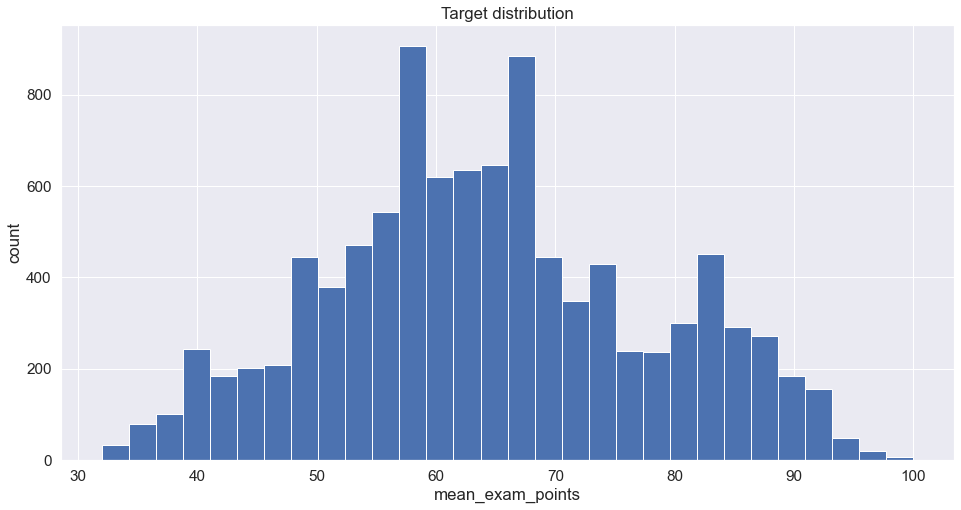

In [927]:
plt.figure(figsize = (16, 8))

df_train['mean_exam_points'].hist(bins=30)
plt.ylabel('сount')
plt.xlabel('mean_exam_points')

plt.title('Target distribution')
plt.show()

In [928]:
# Определяем среднее и медиану целевой переменной
target_mean = round(df_train['mean_exam_points'].mean(), 2)
target_median = df_train['mean_exam_points'].median()
target_mode = df_train['mean_exam_points'].mode()[0]
print(f' Среднее: {target_mean}, Медиана: {target_median}, Мода: {target_mode}')

 Среднее: 64.34, Медиана: 63.0, Мода: 65.0


Из гистограммы видно, распределение отлично от нормального.\
Однако, значения моды, медианы и среднего достаточно близки.

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


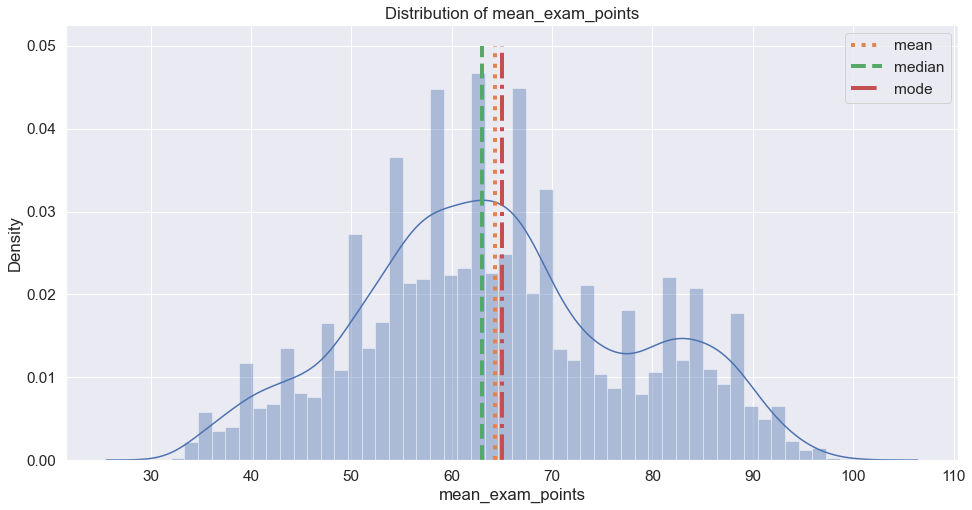

In [929]:
plt.figure(figsize = (16, 8))

sns.distplot(df_train['mean_exam_points'], bins=50)

y = np.linspace(0, 0.05, 10)
plt.plot([target_mean] * 10, y, label='mean', linestyle=':', linewidth=4)
plt.plot([target_median] * 10, y, label='median', linestyle='--', linewidth=4)
plt.plot([target_mode] * 10, y, label='mode', linestyle='-.', linewidth=4)

plt.title('Distribution of mean_exam_points')
plt.legend()
plt.show()

Проверим правило трех сигм:

In [930]:
three_sigma_rule(df_train, ['mean_exam_points'])

Для признака mean_exam_points выполняется правило трех сигм 



**Вывод:** Целевая переменная имеет распределение, отличное от нормального.

### $\S 1.4.$ Анализ количественных признаков <a class="anchor" id="par1.4">

In [931]:
# Собираем количественные признаки
num_features = ['age', 'years_of_experience', 'lesson_price']
df_train[num_features].head()

,age,years_of_experience,lesson_price
0,40.0,0.0,1400.0
1,48.0,4.0,2850.0
2,39.0,0.0,1200.0
3,46.0,5.0,1400.0
4,43.0,1.0,1500.0


In [932]:
# Смотрим статистики количественных признаков
df_train[num_features].describe()

,age,years_of_experience,lesson_price
count,10000.000000,10000.000000,10000.000000
mean,45.878000,1.986800,1699.105000
std,8.043929,1.772213,524.886654
min,23.000000,0.000000,200.000000
25%,40.000000,0.000000,1300.000000
50%,46.000000,2.000000,1500.000000
75%,51.000000,3.000000,2150.000000
max,68.000000,10.000000,3950.000000


array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'years_of_experience'}>],
       [<AxesSubplot:title={'center':'lesson_price'}>, <AxesSubplot:>]],
      dtype=object)

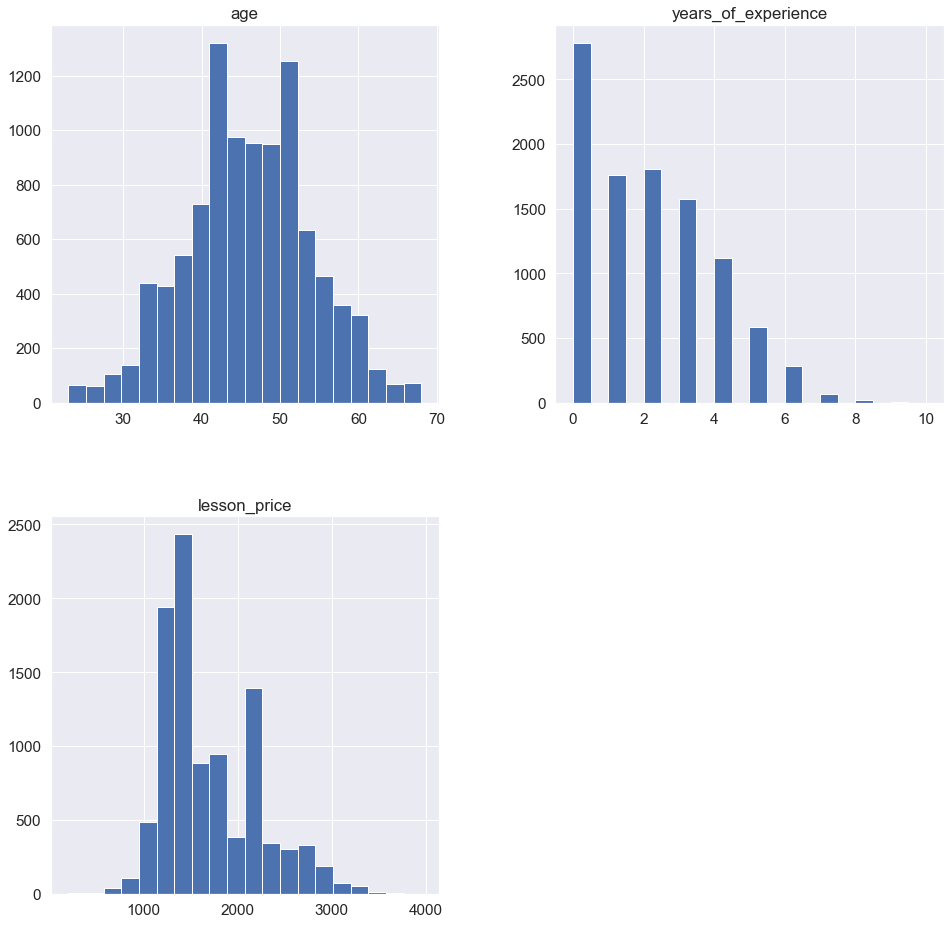

In [933]:
# Строим гистограммы для признаков
df_train[num_features].hist(figsize=(16,16), bins=20, grid=True)

На диаграммах видно, что распределения количественных признаков отличны от нормального.

Проверим равенства моды, медианы и среднего дня признаков

In [934]:
#проверям равенство моды, медианы и среднего
for num_feature in num_features:
    print(f'{num_feature}: mean: {df_train[num_feature].mean()}, median: {df_train[num_feature].median()}, mode: {df_train[num_feature].mode()[0]} \n')

age: mean: 45.878, median: 46.0, mode: 48.0 

years_of_experience: mean: 1.9868, median: 2.0, mode: 0.0 

lesson_price: mean: 1699.105, median: 1500.0, mode: 1450.0 



Значения моды, медианы и среднего у всех признаков близки.

Проверим правило трех сигм

In [935]:
three_sigma_rule(df_train, num_features)

Для признака age выполняется правило трех сигм 

Для признака years_of_experience не выполняется правило трех сигм 

Для признака lesson_price не выполняется правило трех сигм 



Проведем аналогичный анализ для количественных признаков тренировочного датасета

age: mean: 45.9728, median: 46.0, mode: 46.0 

years_of_experience: mean: 1.98, median: 2.0, mode: 0.0 

lesson_price: mean: 1697.095, median: 1500.0, mode: 1450.0 

Для признака age выполняется правило трех сигм 

Для признака years_of_experience не выполняется правило трех сигм 

Для признака lesson_price не выполняется правило трех сигм 



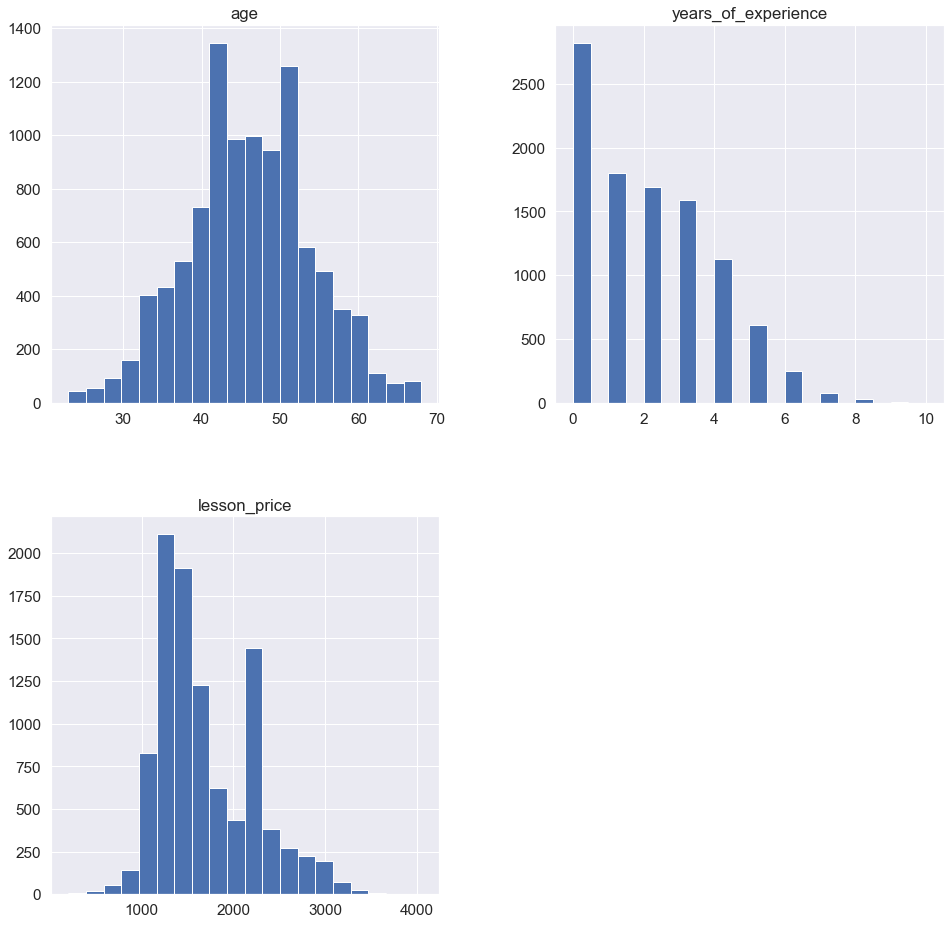

In [936]:
#строим гистограммы
df_test[num_features].hist(figsize=(16,16), bins=20, grid=True)

#проверям равенство моды, медианы и среднего
for num_feature in num_features:
    print(f'{num_feature}: mean: {df_test[num_feature].mean()}, median: {df_test[num_feature].median()}, mode: {df_test[num_feature].mode()[0]} \n')

#проверяем правило трех сигм
three_sigma_rule(df_test, num_features)

**Вывод:** Распределения количественных признаков в тренировочном и тестовом датасетах похожи между собой и отличны от нормального.

### $\S 1.5.$ Обработка выбросов в количественных признаках <a class="anchor" id="par1.5">

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


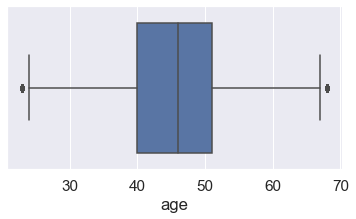

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


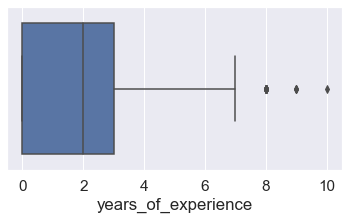

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


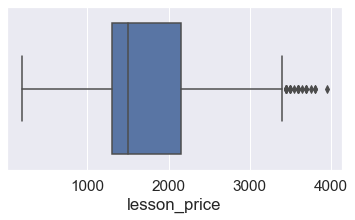

In [937]:
#найдем выбросы в количественных признаках тренировочного датасета
finding_outliers(df_train, num_features)

Вычислим количество потенциальных выбросов

In [938]:
#Оценим количесто данных, в которых признак age <30 или age > 60
df_train.loc[(df_train['age'] < 30) | (df_train['age'] >60), 'age'].value_counts().sort_index()

23.0    39
24.0     9
25.0    17
26.0    26
27.0    34
28.0    51
29.0    55
61.0    84
62.0    72
63.0    50
64.0    37
65.0    31
66.0    17
67.0    16
68.0    38
Name: age, dtype: int64

Выбросов в признаке 'age' нет.

In [939]:
#Оценим количесто данных, в которых признак age <30 или age > 60
df_train.loc[df_train['years_of_experience'] > 7, 'years_of_experience'].value_counts().sort_index()

8.0     20
9.0      3
10.0     1
Name: years_of_experience, dtype: int64

In [940]:
#провеяем минимальный возраст репетиторов с большим стажем
df_train.loc[df_train['years_of_experience'] > 7, 'age'].min()

34.0

Выбросов в признаке 'years_of_experience' нет.

In [941]:
#Оценим количесто данных, в которых признак lesson_price >= 3400
df_train.loc[df_train['lesson_price'] >= 3400, 'lesson_price'].value_counts().sort_index()

3400.0    6
3450.0    7
3500.0    4
3550.0    1
3600.0    5
3650.0    1
3700.0    3
3750.0    1
3800.0    2
3950.0    1
Name: lesson_price, dtype: int64

Выбросов в признаке 'lesson_price' нет.

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


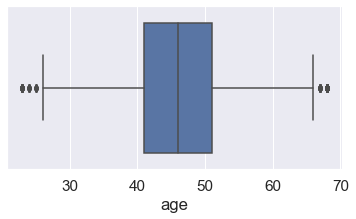

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


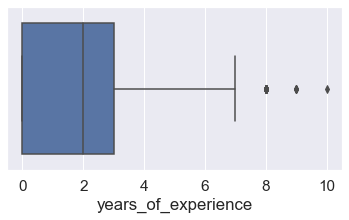

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


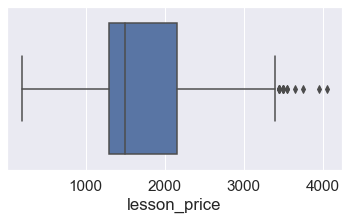

In [942]:
#найдем выбросы в количественных признаках тестового датасета
finding_outliers(df_test, num_features)

In [943]:
#Оценим количесто данных, в которых признак age <30 или age > 65
df_test.loc[(df_test['age'] < 30) | (df_test['age'] >65), 'age'].value_counts().sort_index()

23.0    24
24.0    11
25.0     9
26.0    26
27.0    29
28.0    41
29.0    50
66.0    26
67.0    18
68.0    38
Name: age, dtype: int64

Выбросов в признаке 'age' нет.

In [944]:
#провеяем минимальный возраст репетиторов с большим стажем
df_test.loc[df_test['years_of_experience'] > 7, 'age'].min()

33.0

Выбросов в признаке 'years_of_experience' нет.

In [945]:
#Оценим количесто данных, в которых признак lesson_price >= 3400
df_test.loc[df_test['lesson_price'] >= 3400, 'lesson_price'].value_counts().sort_index()

3400.0    6
3450.0    5
3500.0    5
3550.0    2
3650.0    1
3750.0    1
3950.0    1
4050.0    1
Name: lesson_price, dtype: int64

Выбросов в признаке 'lesson_price' нет.

**Вывод:** выбросов в признаках нет.

### $\S 1.6.$ Анализ категориальных признаков <a class="anchor" id="par1.6">

In [946]:
# Собираем категориальные признаки
cat_features = ['qualification', 'physics', 'chemistry', 'biology', 'english', 'geography', 'history']

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


qualification

1.0    4884
2.0    3087
3.0    1979
4.0      50
Name: qualification, dtype: int64
********************************************************************************



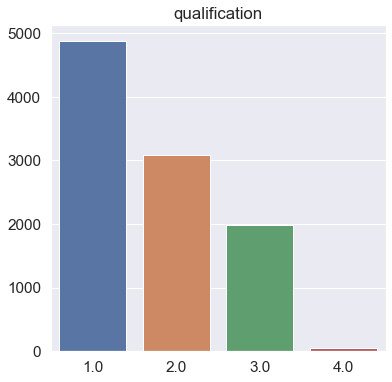

physics

0.0    6250
1.0    3750
Name: physics, dtype: int64
********************************************************************************



C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


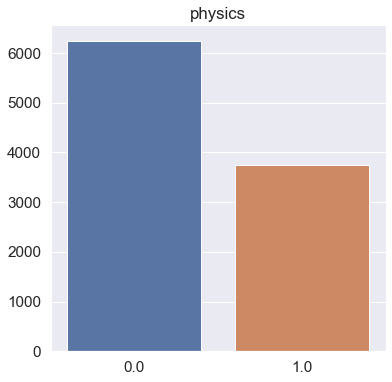

chemistry

0.0    8671
1.0    1329
Name: chemistry, dtype: int64
********************************************************************************



C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


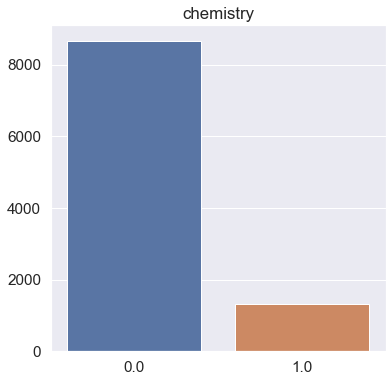

biology

0.0    8904
1.0    1096
Name: biology, dtype: int64
********************************************************************************



C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


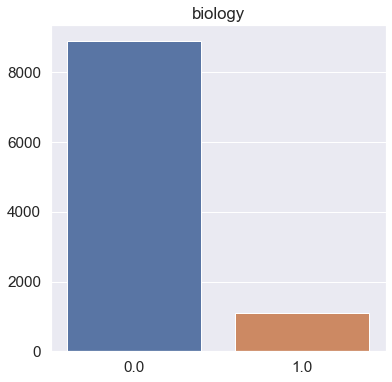

english

0.0    9463
1.0     537
Name: english, dtype: int64
********************************************************************************



C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


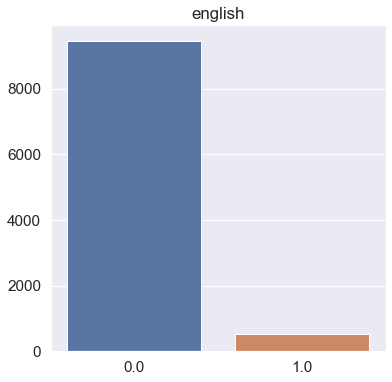

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


geography

0.0    9679
1.0     321
Name: geography, dtype: int64
********************************************************************************



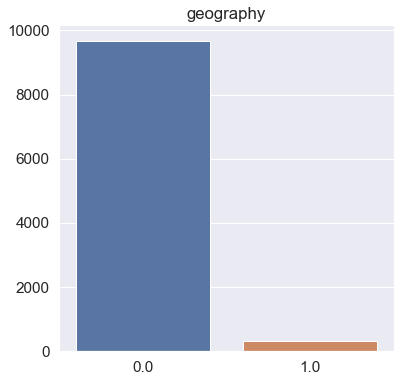

history

0.0    9806
1.0     194
Name: history, dtype: int64
********************************************************************************



C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


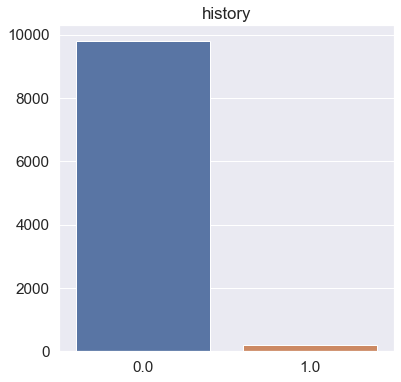

In [947]:
# Анализ категориальных признаков для тренировочного датасета
cat_features_analysis(df_train, cat_features)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


qualification

1.0    4977
2.0    2998
3.0    1979
4.0      46
Name: qualification, dtype: int64
********************************************************************************



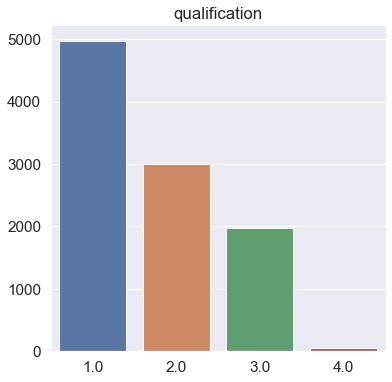

physics

0.0    6187
1.0    3813
Name: physics, dtype: int64
********************************************************************************



C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


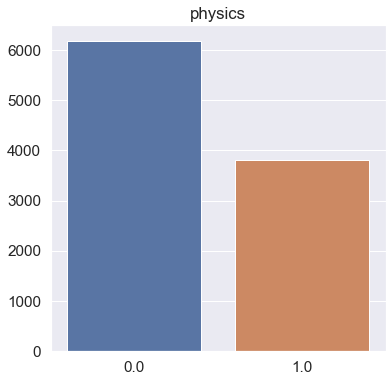

chemistry

0.0    8765
1.0    1235
Name: chemistry, dtype: int64
********************************************************************************



C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


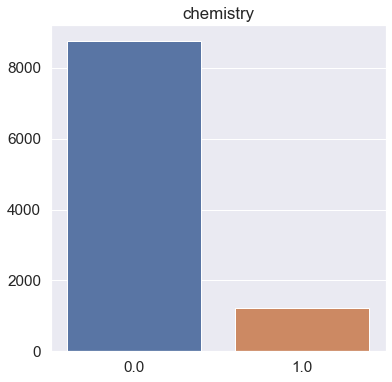

biology

0.0    8799
1.0    1201
Name: biology, dtype: int64
********************************************************************************



C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


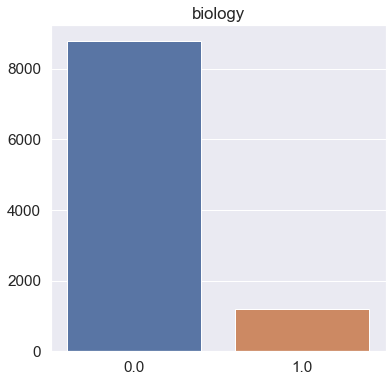

english

0.0    9440
1.0     560
Name: english, dtype: int64
********************************************************************************



C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


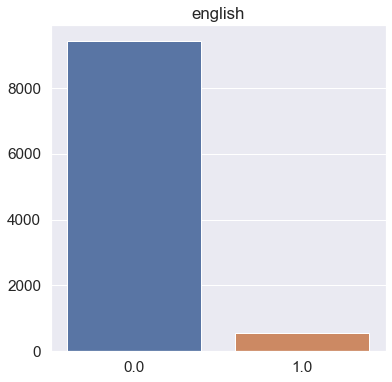

geography

0.0    9686
1.0     314
Name: geography, dtype: int64
********************************************************************************



C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


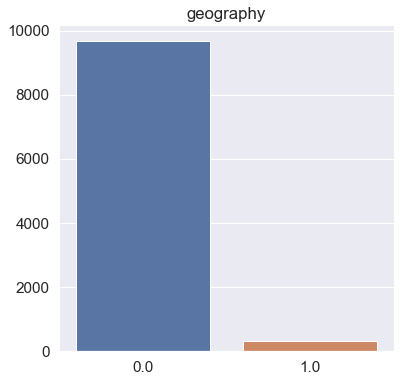

history

0.0    9816
1.0     184
Name: history, dtype: int64
********************************************************************************



C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


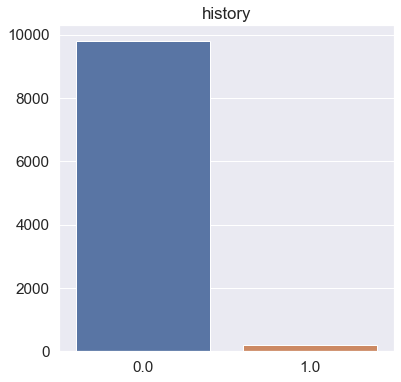

In [948]:
# Анализ категориальных признаков для тестового датасета
cat_features_analysis(df_test, cat_features)

### $\S 1.7.$ Корреляционный анализ <a class="anchor" id="par1.7">

Построим матрицу корреляции целевой переменной с количественными признаками тренировочного датасета

In [949]:
df_train.corr(method='spearman')

,age,years_of_experience,lesson_price,mean_exam_points
age,1.000000,0.037624,-0.007134,-0.008663
years_of_experience,0.037624,1.000000,0.175073,0.168237
lesson_price,-0.007134,0.175073,1.000000,0.662184
mean_exam_points,-0.008663,0.168237,0.662184,1.000000


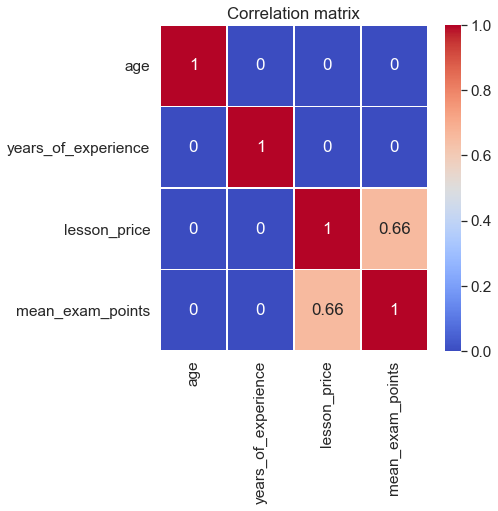

In [950]:
plt.figure(figsize = (6,6))

sns.set(font_scale=1.4)

corr_matrix = df_train.corr(method='spearman')
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0
sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

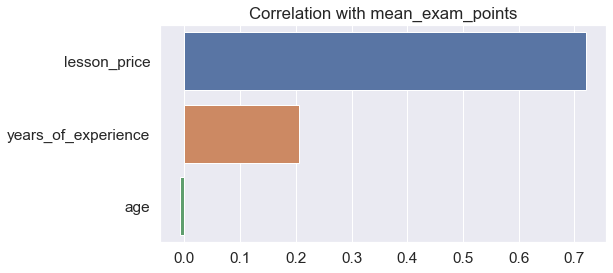

In [951]:
corr_with_target = df_train.corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(8, 4))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with mean_exam_points')
plt.show()

Наибольшую корреляцию с целевой переменной имеет признак lesson_price

Оценим зависимости категориальных признаков от целевой переменной

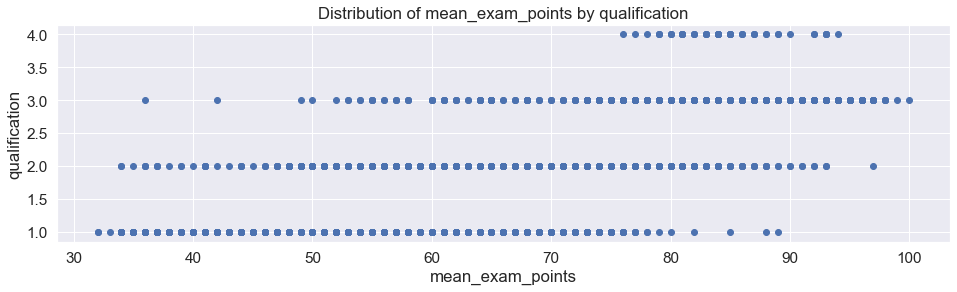

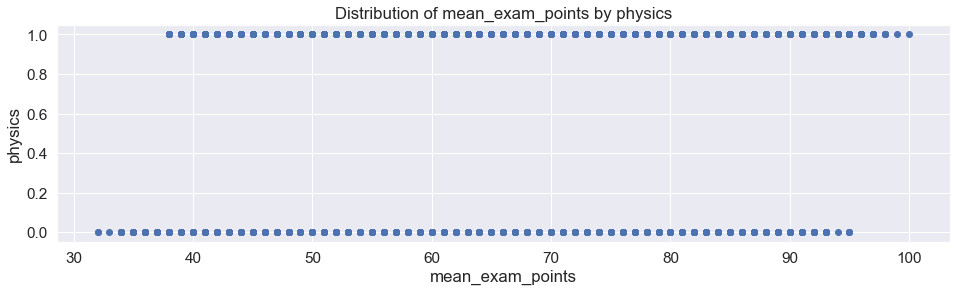

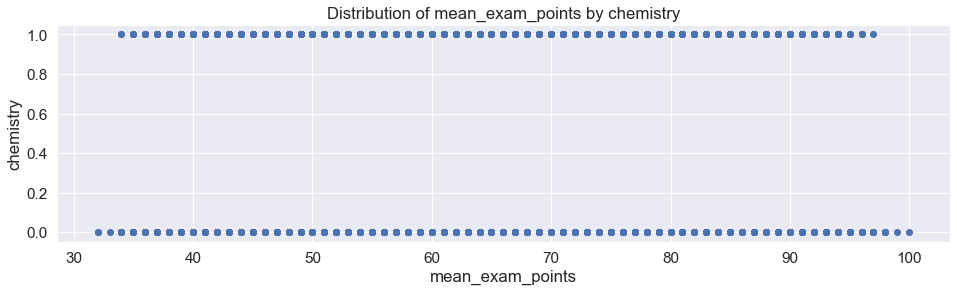

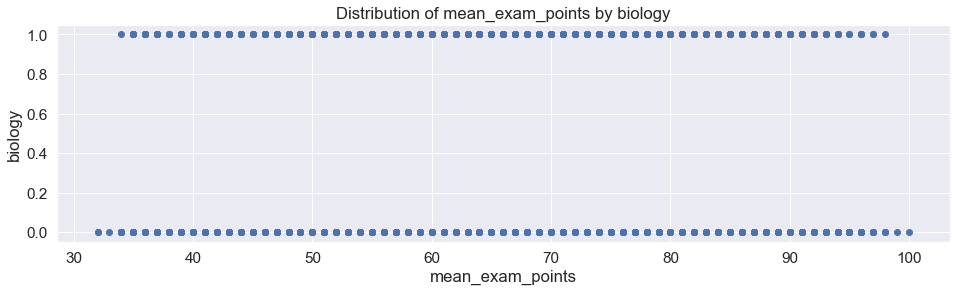

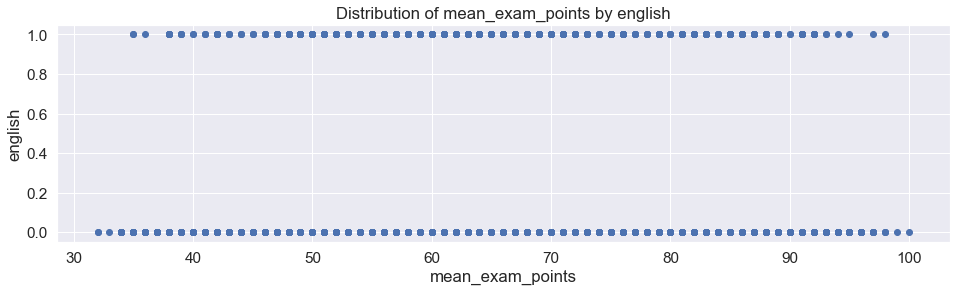

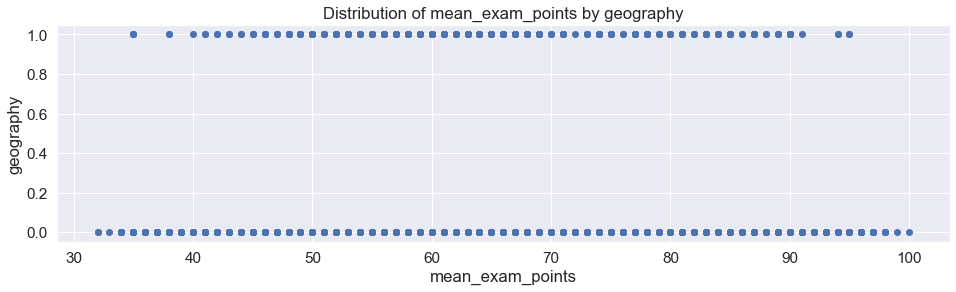

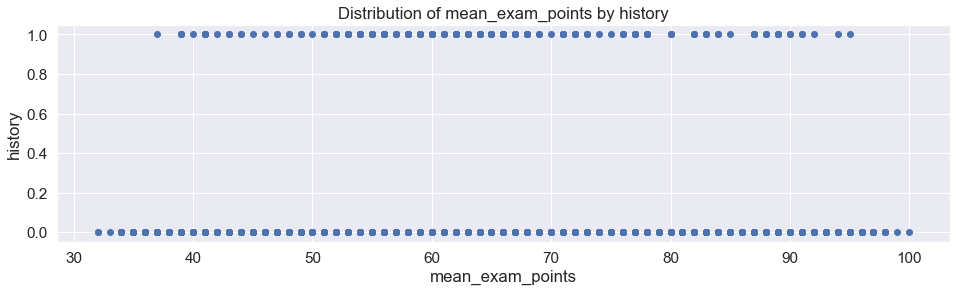

In [952]:
for cat_feature in cat_features:
    plt.figure(figsize=(16, 4))

    plt.scatter(df_train['mean_exam_points'], df_train[cat_feature])

    plt.xlabel('mean_exam_points')
    plt.ylabel(cat_feature)
    plt.title(f'Distribution of mean_exam_points by {cat_feature}')
    plt.show()

**Вывод:** с целевой переменной коррелирует признак lesson_price; у преподавателей с высокой квалификацией (3 и 4) средняя оценка на экзамене > 50; если преподаватель специализируется только на физике, средний результат за экзамен будет выше.

### $\S 1.8.$ Построение новых признаков <a class="anchor" id="par1.8">

In [953]:
df_train_without_target = df_train.drop('mean_exam_points', 1)
df_train_without_target.head()

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history
0,0,40.0,0.0,1400.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
1,1,48.0,4.0,2850.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0
2,2,39.0,0.0,1200.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,46.0,5.0,1400.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,43.0,1.0,1500.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


**Dummies признаки**

In [954]:
#Делаем бинарные признаки
for feature in ['physics', 'chemistry', 'biology', 'english', 'geography', 'history']:
    df_train_without_target[feature] = df_train_without_target[feature].astype(int)

In [955]:
df_train_without_target = pd.concat([df_train_without_target, pd.get_dummies(df_train_without_target["qualification"], prefix="qualification")], axis=1)
df_train_without_target.head()

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,qualification_1.0,qualification_2.0,qualification_3.0,qualification_4.0
0,0,40.0,0.0,1400.0,1.0,1,0,0,0,1,0,1,0,0,0
1,1,48.0,4.0,2850.0,3.0,1,0,0,0,0,0,0,0,1,0
2,2,39.0,0.0,1200.0,1.0,0,0,0,0,0,0,1,0,0,0
3,3,46.0,5.0,1400.0,1.0,0,0,0,0,0,0,1,0,0,0
4,4,43.0,1.0,1500.0,1.0,0,0,0,0,0,0,1,0,0,0


**Feature  binarization and encoding**

Добавим признаки числа преподаваемых предметов и мультипредметность преподавателя

In [956]:
#добавляем признак числа предметов
df_train_without_target['num_of_subjects'] = df_train_without_target[['physics', 'chemistry', 'biology', 'english', 'geography', 'history']].sum(axis = 1)

#смотрим число значений этого признака
df_train_without_target['num_of_subjects'].value_counts()

0    4377
1    4197
2    1256
3     162
4       8
Name: num_of_subjects, dtype: int64

In [957]:
#добавляем признак многопрофильного преподавателя
df_train_without_target['multi_subjects_tutor'] = np.where(df_train_without_target['num_of_subjects'] >=3, 1, 0)
df_train_without_target.head()

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,qualification_1.0,qualification_2.0,qualification_3.0,qualification_4.0,num_of_subjects,multi_subjects_tutor
0,0,40.0,0.0,1400.0,1.0,1,0,0,0,1,0,1,0,0,0,2,0
1,1,48.0,4.0,2850.0,3.0,1,0,0,0,0,0,0,0,1,0,1,0
2,2,39.0,0.0,1200.0,1.0,0,0,0,0,0,0,1,0,0,0,0,0
3,3,46.0,5.0,1400.0,1.0,0,0,0,0,0,0,1,0,0,0,0,0
4,4,43.0,1.0,1500.0,1.0,0,0,0,0,0,0,1,0,0,0,0,0


Определяем преподавателей, которые специализируются только на физике

In [958]:
df_train_without_target['only_physics_tutor'] = np.where((df_train_without_target['physics'] == 1) & (df_train_without_target['chemistry'] == 0) & (df_train_without_target['biology'] == 0) & (df_train_without_target['english'] == 0) & (df_train_without_target['geography'] == 0) & (df_train_without_target['history'] == 0), 1, 0)
df_train_without_target.head()

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,qualification_1.0,qualification_2.0,qualification_3.0,qualification_4.0,num_of_subjects,multi_subjects_tutor,only_physics_tutor
0,0,40.0,0.0,1400.0,1.0,1,0,0,0,1,0,1,0,0,0,2,0,0
1,1,48.0,4.0,2850.0,3.0,1,0,0,0,0,0,0,0,1,0,1,0,1
2,2,39.0,0.0,1200.0,1.0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,3,46.0,5.0,1400.0,1.0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,4,43.0,1.0,1500.0,1.0,0,0,0,0,0,0,1,0,0,0,0,0,0


Добавляем признаки опытного и высоко квалифицированного преподавателя

In [959]:
#добавим признак опытного преподавателя
df_train_without_target['experienced_tutor'] = np.where(df_train_without_target['years_of_experience'] >=5, 1, 0)
#добавим признак высоко квалифицированного преподавателя
df_train_without_target['hight_qualification'] = np.where((df_train_without_target['qualification'] == 3) | (df_train_without_target['qualification'] == 4), 1, 0)

df_train_without_target.head()

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,qualification_1.0,qualification_2.0,qualification_3.0,qualification_4.0,num_of_subjects,multi_subjects_tutor,only_physics_tutor,experienced_tutor,hight_qualification
0,0,40.0,0.0,1400.0,1.0,1,0,0,0,1,0,1,0,0,0,2,0,0,0,0
1,1,48.0,4.0,2850.0,3.0,1,0,0,0,0,0,0,0,1,0,1,0,1,0,1
2,2,39.0,0.0,1200.0,1.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,3,46.0,5.0,1400.0,1.0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
4,4,43.0,1.0,1500.0,1.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


Добавим признак стоимости урока

In [960]:
#оцениваем различные значения признака
df_train_without_target['lesson_price'].value_counts().sort_index()

200.0     2
250.0     2
300.0     1
350.0     3
400.0     1
         ..
3650.0    1
3700.0    3
3750.0    1
3800.0    2
3950.0    1
Name: lesson_price, Length: 74, dtype: int64

In [961]:
#добавим признаки оценки стоимости урока
df_train_without_target['expensive_lesson'] = np.where(df_train_without_target['lesson_price'] >= 2000 , 1, 0)
df_train_without_target['cheap_lesson'] = np.where(df_train_without_target['lesson_price'] <= 1500, 1, 0)
df_train_without_target.head()

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,...,qualification_2.0,qualification_3.0,qualification_4.0,num_of_subjects,multi_subjects_tutor,only_physics_tutor,experienced_tutor,hight_qualification,expensive_lesson,cheap_lesson
0,0,40.0,0.0,1400.0,1.0,1,0,0,0,1,...,0,0,0,2,0,0,0,0,0,1
1,1,48.0,4.0,2850.0,3.0,1,0,0,0,0,...,0,1,0,1,0,1,0,1,1,0
2,2,39.0,0.0,1200.0,1.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,3,46.0,5.0,1400.0,1.0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
4,4,43.0,1.0,1500.0,1.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


Добавим признак оценки возраста преподавателя

In [962]:
df_train_without_target['young_tutor'] = np.where(df_train_without_target['age'] <= 45, 1, 0)
df_train_without_target.head()

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,...,qualification_3.0,qualification_4.0,num_of_subjects,multi_subjects_tutor,only_physics_tutor,experienced_tutor,hight_qualification,expensive_lesson,cheap_lesson,young_tutor
0,0,40.0,0.0,1400.0,1.0,1,0,0,0,1,...,0,0,2,0,0,0,0,0,1,1
1,1,48.0,4.0,2850.0,3.0,1,0,0,0,0,...,1,0,1,0,1,0,1,1,0,0
2,2,39.0,0.0,1200.0,1.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
3,3,46.0,5.0,1400.0,1.0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
4,4,43.0,1.0,1500.0,1.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1


Аналогичным образом построим новые признаки для тестового датасета

In [963]:
df_test = new_features_for_test(df_test)
df_test.head()

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,...,qualification_3.0,qualification_4.0,num_of_subjects,multi_subjects_tutor,only_physics_tutor,experienced_tutor,hight_qualification,expensive_lesson,cheap_lesson,young_tutor
0,10000,46.0,3.0,1050.0,1.0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,1,0
1,10001,43.0,3.0,1850.0,2.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,10002,52.0,1.0,1550.0,1.0,1,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
3,10003,57.0,6.0,2900.0,3.0,1,0,1,0,0,...,1,0,2,0,0,1,1,1,0,0
4,10004,44.0,4.0,3150.0,3.0,1,0,0,0,0,...,1,0,1,0,1,0,1,1,0,1


**Вывод:** в тренировочном и тестовом датасете построены новые признаки.

## <center>Глава 2. Построение модели регрессии <a class="anchor" id="part2"></a><center>

### $\S 2.1.$ Отбор признаков <a class="anchor" id="par2.1">

Проанализируем еще раз матрицу корреляции тренировочного датасета (после добавления новых признаков)

In [964]:
df_train = df_train_without_target.merge(df_train[['Id','mean_exam_points']], on=["Id"])
df_train.head()

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,...,qualification_4.0,num_of_subjects,multi_subjects_tutor,only_physics_tutor,experienced_tutor,hight_qualification,expensive_lesson,cheap_lesson,young_tutor,mean_exam_points
0,0,40.0,0.0,1400.0,1.0,1,0,0,0,1,...,0,2,0,0,0,0,0,1,1,63.0
1,1,48.0,4.0,2850.0,3.0,1,0,0,0,0,...,0,1,0,1,0,1,1,0,0,86.0
2,2,39.0,0.0,1200.0,1.0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,53.0
3,3,46.0,5.0,1400.0,1.0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,56.0
4,4,43.0,1.0,1500.0,1.0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,59.0


In [965]:
df_train.corr(method='spearman')

,age,years_of_experience,lesson_price,physics,chemistry,biology,english,geography,history,qualification_1.0,...,qualification_4.0,num_of_subjects,multi_subjects_tutor,only_physics_tutor,experienced_tutor,hight_qualification,expensive_lesson,cheap_lesson,young_tutor,mean_exam_points
age,1.000000,0.037624,-0.007134,0.002990,-0.000263,-0.005483,-0.014530,0.012940,0.009872,-0.005851,...,0.000679,-0.000938,0.016788,0.011295,0.132549,-0.014010,-0.003835,-0.000067,-0.865994,-0.008663
years_of_experience,0.037624,1.000000,0.175073,0.006199,0.004088,-0.004977,-0.009165,-0.011618,0.020719,-0.104811,...,0.044117,0.004644,-0.014345,0.001424,0.520339,0.220004,0.161486,-0.195591,-0.034541,0.168237
lesson_price,-0.007134,0.175073,1.000000,-0.003285,0.003005,-0.003708,-0.014837,0.011171,-0.004132,-0.706100,...,0.088527,-0.001588,-0.013088,0.009525,0.144937,0.630791,0.789326,-0.866840,-0.001170,0.662184
physics,0.002990,0.006199,-0.003285,1.000000,0.019852,0.000661,0.004238,0.001904,0.004867,-0.010951,...,-0.016839,0.692757,0.145806,0.758276,0.004908,0.004173,0.003686,0.002892,-0.009767,0.187729
chemistry,-0.000263,0.004088,0.003005,0.019852,1.000000,0.007866,0.009974,-0.004447,-0.008079,0.003487,...,-0.002694,0.439937,0.219690,-0.229949,-0.003584,-0.000479,-0.002456,0.003054,0.007753,0.016897
biology,-0.005483,-0.004977,-0.003708,0.000661,0.007866,1.000000,0.010146,-0.013042,0.010995,0.006221,...,0.002360,0.392480,0.236159,-0.206071,0.004112,-0.007465,0.003194,-0.003447,0.007786,0.025632
english,-0.014530,-0.009165,-0.014837,0.004238,0.009974,0.010146,1.000000,-0.008148,-0.004560,0.006859,...,-0.004308,0.278230,0.205454,-0.139919,-0.002337,-0.006571,-0.002438,0.012734,0.011422,0.010727
geography,0.012940,-0.011618,0.011171,0.001904,-0.004447,-0.013042,-0.008148,1.000000,-0.005049,-0.014501,...,0.003177,0.207881,0.125265,-0.106965,-0.009275,-0.011470,0.007291,-0.016775,-0.010565,0.014234
history,0.009872,0.020719,-0.004132,0.004867,-0.008079,0.010995,-0.004560,-0.005049,1.000000,-0.002538,...,-0.009971,0.162980,0.132934,-0.082615,0.008309,-0.011471,-0.014174,-0.001125,-0.013431,-0.001088
qualification_1.0,-0.005851,-0.104811,-0.706100,-0.010951,0.003487,0.006221,0.006859,-0.014501,-0.002538,1.000000,...,-0.069262,-0.005508,-0.004686,-0.020040,-0.090227,-0.492955,-0.601327,0.633176,0.004909,-0.605578


Визуализируем матрицу корреляции

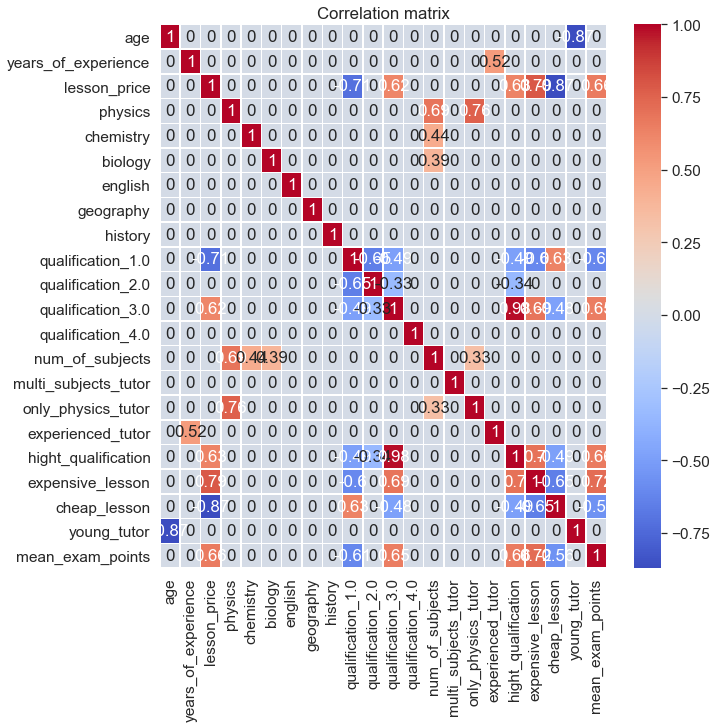

In [966]:
plt.figure(figsize = (10,10))

sns.set(font_scale=1.4)

corr_matrix = df_train.corr(method='spearman')
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0
sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

**Вывод:** коррелируют признаки: \
lesson_price - qualification_1.0, lesson_price - qualification_3.0, lesson_price - hight_qualification, \
qualification_1.0 - expensive_lesson, cheap_lesson,\
qualification_3.0 - expensive_lesson, cheap_lesson.

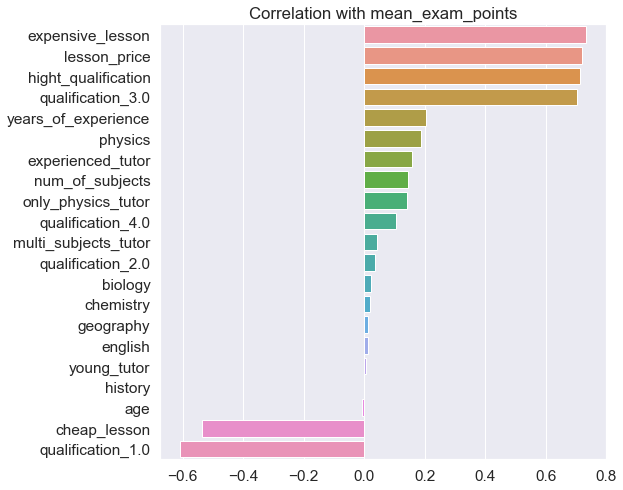

In [967]:
# Строим матрицу корреляции целевой переменной с признаками тренировочного датасета
corr_with_target = df_train.corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(8, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with mean_exam_points')
plt.show()

**Вывод:** с целевой переменной коррелируют признаки expensive_lesson, lesson_price, hight_qualification, qualification_3.0, qualification_1.0, cheap_lesson.

In [968]:
#признаки для построения модели (убираем категориальные признаки и целевую переменную)
features_for_model = df_train.columns.tolist()
for feature in ['Id', 'qualification', 'mean_exam_points']:
    features_for_model.remove(feature)
features_for_model

['age',
 'years_of_experience',
 'lesson_price',
 'physics',
 'chemistry',
 'biology',
 'english',
 'geography',
 'history',
 'qualification_1.0',
 'qualification_2.0',
 'qualification_3.0',
 'qualification_4.0',
 'num_of_subjects',
 'multi_subjects_tutor',
 'only_physics_tutor',
 'experienced_tutor',
 'hight_qualification',
 'expensive_lesson',
 'cheap_lesson',
 'young_tutor']

In [969]:
#целевая переменная
target = 'mean_exam_points'

### $\S 2.2.$ Реализация алгоритма модели <a class="anchor" id="par2.2">

Реализуем алгоритм градиентного бустинга (основанный на решающем дереве)

In [918]:
# Реализуем класс узла
class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле
        
# Реаизуем класс терминального узла (листа)
class Leaf:
    
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets
        self.prediction = self.predict()
        
    def predict(self):
        # найдем среднее значение целевой переменной в выборке
        prediction = sum(self.targets) / self.targets.shape[0]
        
        return prediction       

# Расчет дисперсии
def variance(targets):
    # вычислим среднее значение целевого признака
    mean = sum(targets) / targets.shape[0]
        
    #вычисляем дисперсию
    var = 1/targets.shape[0] * sum((targets - mean) ** 2)
    return var

# Расчет качества
def quality(left_targets, right_targets, current_variance):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_targets.shape[0]) / (left_targets.shape[0] + right_targets.shape[0])
    
    return current_variance - p * variance(left_targets) - (1 - p) * variance(right_targets)

# Разбиение датасета в узле
def split(data, targets, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_targets = targets[left]
    false_targets = targets[right]
     
    return true_data, false_data, true_targets, false_targets

# Нахождение наилучшего разбиения
def find_best_split(data, targets, min_samples_leaf):
    
    current_variance = variance(targets)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_targets, false_targets = split(data, targets, index, t)
           
            #  КРИТЕРИЙ ОСТАНОВА: пропускаем разбиения, в которых в узле остается менее  min_samples_leaf объектов
            if len(true_data) <  min_samples_leaf or len(false_data) <  min_samples_leaf:
                continue
            
            current_quality = quality(true_targets, false_targets, current_variance)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

# Построение дерева с помощью рекурсивной функции
def build_tree(data, targets, max_depth, min_samples_leaf, depth = 1):

    #ищем лучшее разбиение
    quality, t, index = find_best_split(data, targets, min_samples_leaf)
    
   # КРИТЕРИЙ ОСТАНОВА: прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, targets)

    #осуществляем разбиение по лучшему найденному
    true_data, false_data, true_targets, false_targets = split(data, targets, index, t)

    # КРИТЕРИЙ ОСТАНОВА: ограничение максимальной глубины дерева
    if depth >= max_depth:
        true_branch = Leaf(true_data, true_targets)
        false_branch = Leaf(false_data, false_targets)
        return Node(index, t, true_branch, false_branch)
           
    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_targets, max_depth, min_samples_leaf, depth + 1)
    false_branch = build_tree(false_data, false_targets, max_depth, min_samples_leaf, depth + 1)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

def predict(data, tree):
    
    targets = []
    for obj in data:
        prediction = classify_object(obj, tree)
        targets.append(prediction)
    return targets

def gb_predict(X, trees_list, coef_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании прибавляются с шагом eta
    return np.array([sum([eta* coef * predict([x], alg)[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])

#В качестве функционала ошибки используем среднеквадратичную ошибку
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

#производная от функции потерь L(y,z) = (y-z)^2
def bias(y, z):
    return (y - z)

def gb_fit(n_trees, max_depth, min_samples_leaf, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = build_tree(X_train, y_train, max_depth, min_samples_leaf)
        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree = build_tree(X_train, bias(y_train, target), max_depth, min_samples_leaf)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

### $\S 2.3.$ Построение модели <a class="anchor" id="par2.3">

In [1033]:
#матрица признаков
X = df_train[features_for_model]
#целевой вектор
y = df_train[target]

In [1034]:
#сохраняем датасеты
X.to_csv('data.csv', index=None)
y.to_csv('target.csv', index=None)

In [1035]:
#разбиваем выборку на обучающую и тестовую
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, shuffle=True, random_state=21
)

Train R2:	0.796
Test R2:	0.774


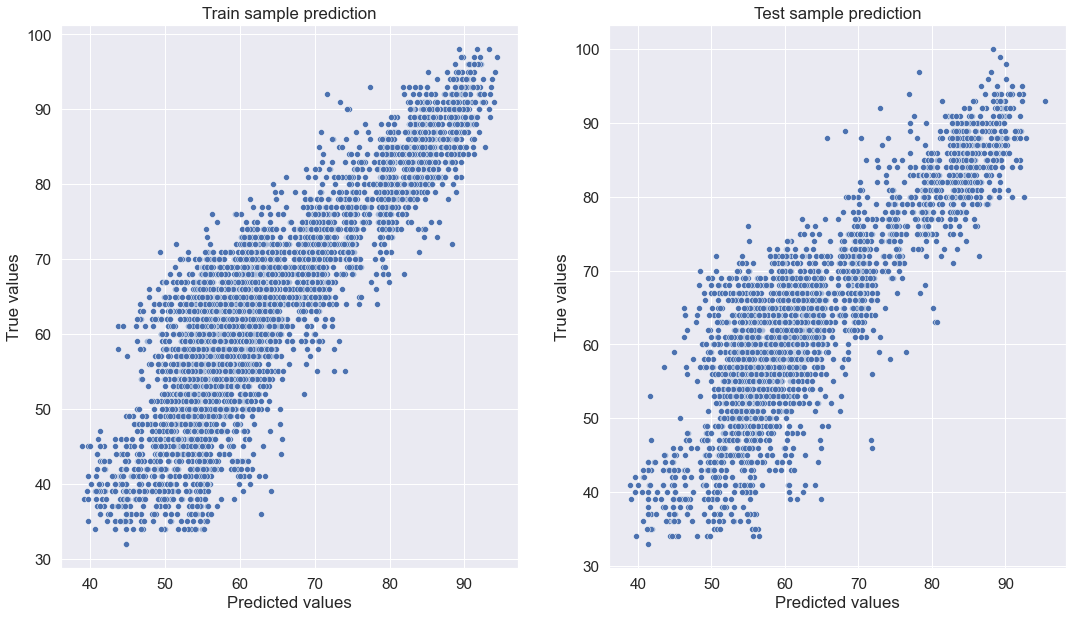

In [1036]:
# Число деревьев в ансамбле
n_trees = 500 
#при n_trees = 1000 -- r2 будет хуже

# Максимальная глубина деревьев
max_depth = 3 
#при max_depth = 4 -- r2 = 0.772, max_depth = 3 -- r2 = 0.773, max_depth = 2 -- r2 = 0.758

#минимальное распределение в листе
min_samples_leaf = 50  
#при min_samples_leaf = 100 -- 0.7725, min_samples_leaf = 50 -- 0.774, min_samples_leaf = 25 -- 0.7738, min_samples_leaf = 10 -- 0.773, min_samples_leaf = 5 -- 0.773, min_samples_leaf = 3 -- 0,773

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees

# Шаг
eta = 0.1 
#при eta =1 -- 0.753, eta =0.5 -- 0.766 

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, min_samples_leaf, X_train.values, X_test.values, y_train.values, y_test.values, coefs, eta)

y_train_pred = gb_predict(X_train.values, trees, coefs, eta)

y_test_pred = gb_predict(X_test.values, trees, coefs, eta)

evaluate_preds(y_train.values, y_train_pred, y_test.values, y_test_pred)

In [1037]:
# Метрика на обучающей выборке
print(f'train r2: {r2_score(y_train.values, y_train_pred)}')
    
# Метрика на  тестовой выборке
print(f'test r2: {r2_score(y_test.values, y_test_pred)}')

train r2: 0.7957655098042703
test r2: 0.7740168035911371


Подбираем параметры

In [1019]:
'''
#Исследуем параметр max_depth

# Максимальная глубина деревьев
max_depth = [i for i in range(1,11,1)]

#минимальное распределение в листе
min_samples_leaf = 3

#количество деревьев
n_trees = 500

# Шаг
eta = 0.1

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees


y_train_pred = []

y_test_pred = []

for i in max_depth:
       
    trees, train_errors, test_errors = gb_fit(n_trees, i, min_samples_leaf, X_train.values, X_test.values, y_train.values, y_test.values, coefs, eta)
    
    train_pred = gb_predict(X_train.values, trees, coefs, eta)

    test_pred = gb_predict(X_test.values, trees, coefs, eta)

    y_train_pred.append(train_pred)
    
    y_test_pred.append(test_pred)
    
    
r2_train = [r2_score(y_train.values, i_pred) for i_pred in y_train_pred]

r2_test = [r2_score(y_test.values, i_pred) for i_pred in y_test_pred]

plt.ylim([0.6,1])
plt.plot(max_depth, r2_train, label='train r2')
plt.plot(max_depth, r2_test, label='test r2')

plt.title('Dependence of R2 on max_depth')
plt.xlabel('max_depth')
plt.ylabel('R2')
plt.legend(loc='upper right')
plt.show()

print(r2_train)
print(r2_test)

оптимальный параметр max_depth = 3
'''

"\n#Исследуем параметр max_depth\n\n# Максимальная глубина деревьев\nmax_depth = [i for i in range(1,11,1)]\n\n#минимальное распределение в листе\nmin_samples_leaf = 3\n\n#количество деревьев\nn_trees = 500\n\n# Шаг\neta = 0.1\n\n# для простоты примем коэффициенты равными 1\ncoefs = [1] * n_trees\n\n\ny_train_pred = []\n\ny_test_pred = []\n\nfor i in max_depth:\n       \n    trees, train_errors, test_errors = gb_fit(n_trees, i, min_samples_leaf, X_train.values, X_test.values, y_train.values, y_test.values, coefs, eta)\n    \n    train_pred = gb_predict(X_train.values, trees, coefs, eta)\n\n    test_pred = gb_predict(X_test.values, trees, coefs, eta)\n\n    y_train_pred.append(train_pred)\n    \n    y_test_pred.append(test_pred)\n    \n    \nr2_train = [r2_score(y_train.values, i_pred) for i_pred in y_train_pred]\n\nr2_test = [r2_score(y_test.values, i_pred) for i_pred in y_test_pred]\n\nplt.ylim([0.6,1])\nplt.plot(max_depth, r2_train, label='train r2')\nplt.plot(max_depth, r2_test, lab

In [1020]:
'''
#Исследуем параметр min_samples_leaf

# Максимальная глубина деревьев
max_depth = 3

#минимальное распределение в листе
min_samples_leaf = [i for i in range(3, 103, 5)]

#количество деревьев
n_trees = 500

# Шаг
eta = 0.1

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees


y_train_pred = []

y_test_pred = []

for i in min_samples_leaf:
       
    trees, train_errors, test_errors = gb_fit(n_trees, max_depth, i, X_train.values, X_test.values, y_train.values, y_test.values, coefs, eta)
    
    train_pred = gb_predict(X_train.values, trees, coefs, eta)

    test_pred = gb_predict(X_test.values, trees, coefs, eta)

    y_train_pred.append(train_pred)
    
    y_test_pred.append(test_pred)
    
    
r2_train = [r2_score(y_train.values, i_pred) for i_pred in y_train_pred]

r2_test = [r2_score(y_test.values, i_pred) for i_pred in y_test_pred]

plt.ylim([0.6,1])
plt.plot(min_samples_leaf, r2_train, label='train r2')
plt.plot(min_samples_leaf, r2_test, label='test r2')

plt.title('Dependence of R2 on min_samples_leaf')
plt.xlabel('min_samples_leaf')
plt.ylabel('R2')
plt.legend(loc='upper right')
plt.show()

print(r2_train)
print(r2_test)

параметр min_samples_leaf = 50
'''

"\n#Исследуем параметр min_samples_leaf\n\n# Максимальная глубина деревьев\nmax_depth = 3\n\n#минимальное распределение в листе\nmin_samples_leaf = [i for i in range(3, 103, 5)]\n\n#количество деревьев\nn_trees = 500\n\n# Шаг\neta = 0.1\n\n# для простоты примем коэффициенты равными 1\ncoefs = [1] * n_trees\n\n\ny_train_pred = []\n\ny_test_pred = []\n\nfor i in min_samples_leaf:\n       \n    trees, train_errors, test_errors = gb_fit(n_trees, max_depth, i, X_train.values, X_test.values, y_train.values, y_test.values, coefs, eta)\n    \n    train_pred = gb_predict(X_train.values, trees, coefs, eta)\n\n    test_pred = gb_predict(X_test.values, trees, coefs, eta)\n\n    y_train_pred.append(train_pred)\n    \n    y_test_pred.append(test_pred)\n    \n    \nr2_train = [r2_score(y_train.values, i_pred) for i_pred in y_train_pred]\n\nr2_test = [r2_score(y_test.values, i_pred) for i_pred in y_test_pred]\n\nplt.ylim([0.6,1])\nplt.plot(min_samples_leaf, r2_train, label='train r2')\nplt.plot(min_sa

In [1021]:
'''
#Исследуем параметр n_trees

# Максимальная глубина деревьев
max_depth = 3

#минимальное распределение в листе
min_samples_leaf = 50

#количество деревьев
n_trees = [i for i in range(500, 1501, 100)]

# Шаг
eta = 0.1


y_train_pred = []

y_test_pred = []

for i in n_trees:
    # для простоты примем коэффициенты равными 1
    coefs = [1] * i
    
    trees, train_errors, test_errors = gb_fit(i, max_depth, min_samples_leaf, X_train.values, X_test.values, y_train.values, y_test.values, coefs, eta)
    
    train_pred = gb_predict(X_train.values, trees, coefs, eta)

    test_pred = gb_predict(X_test.values, trees, coefs, eta)

    y_train_pred.append(train_pred)
    
    y_test_pred.append(test_pred)
    
    
r2_train = [r2_score(y_train.values, i_pred) for i_pred in y_train_pred]

r2_test = [r2_score(y_test.values, i_pred) for i_pred in y_test_pred]

plt.ylim([0.7,1])
plt.plot(n_trees, r2_train, label='train r2')
plt.plot(n_trees, r2_test, label='test r2')

plt.title('Dependence of R2 on n_trees')
plt.xlabel('n_trees')
plt.ylabel('R2')
plt.legend(loc='upper right')
plt.show()

print(r2_train)
print(r2_test)

оптимальный параметр n_trees = 500
'''

"\n#Исследуем параметр n_trees\n\n# Максимальная глубина деревьев\nmax_depth = 3\n\n#минимальное распределение в листе\nmin_samples_leaf = 50\n\n#количество деревьев\nn_trees = [i for i in range(500, 1501, 100)]\n\n# Шаг\neta = 0.1\n\n\ny_train_pred = []\n\ny_test_pred = []\n\nfor i in n_trees:\n    # для простоты примем коэффициенты равными 1\n    coefs = [1] * i\n    \n    trees, train_errors, test_errors = gb_fit(i, max_depth, min_samples_leaf, X_train.values, X_test.values, y_train.values, y_test.values, coefs, eta)\n    \n    train_pred = gb_predict(X_train.values, trees, coefs, eta)\n\n    test_pred = gb_predict(X_test.values, trees, coefs, eta)\n\n    y_train_pred.append(train_pred)\n    \n    y_test_pred.append(test_pred)\n    \n    \nr2_train = [r2_score(y_train.values, i_pred) for i_pred in y_train_pred]\n\nr2_test = [r2_score(y_test.values, i_pred) for i_pred in y_test_pred]\n\nplt.ylim([0.7,1])\nplt.plot(n_trees, r2_train, label='train r2')\nplt.plot(n_trees, r2_test, label

## <center>Глава 3. Прогнозирование на датасете test <a class="anchor" id="part3"></a><center>

### $\S 3.1.$ Предсказание значений целевой переменной с помощью итоговой модели <a class="anchor" id="par3.1">

Train R2:	0.796
Test R2:	0.774


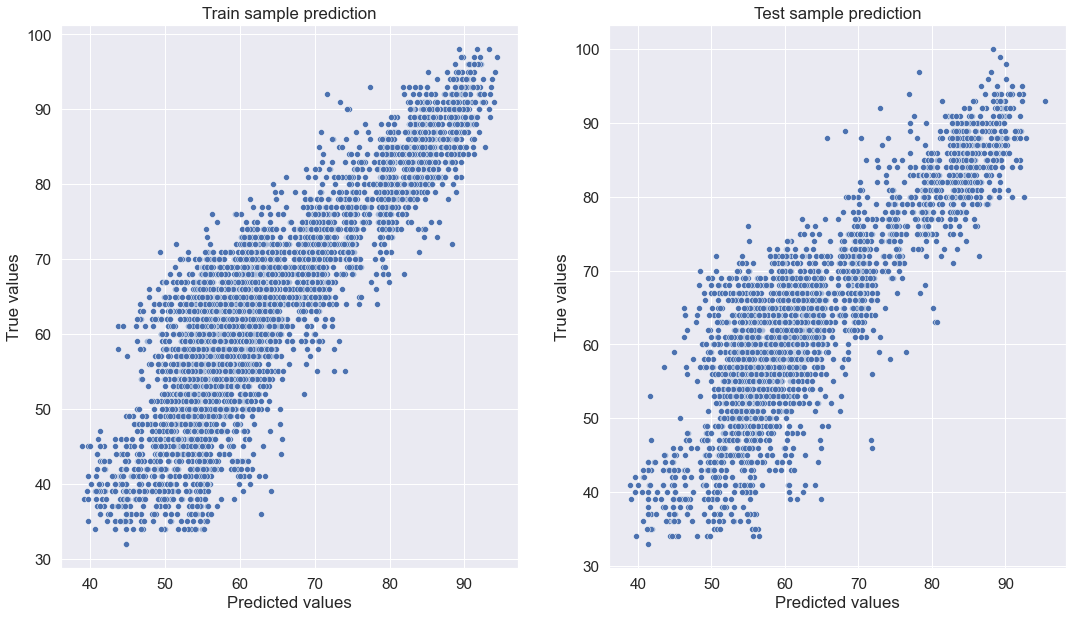

In [1041]:
#Итоговая модель градиентного бустинга с параметрами:

#Число деревьев в ансамбле: 
n_trees = 500

#Максимальная глубина деревьев: 
max_depth = 3

#минимальное распределение в листе: 
min_samples_leaf = 50  

#Коэффициенты деревьев: 
coefs = [1] * n_trees

#Шаг обучения: 
eta = 0.1
    
trees, train_errors, test_errors = gb_fit(n_trees, max_depth, min_samples_leaf, X_train.values, X_test.values, y_train.values, y_test.values, coefs, eta)

y_train_pred = gb_predict(X_train.values, trees, coefs, eta)

y_test_pred = gb_predict(X_test.values, trees, coefs, eta)

evaluate_preds(y_train.values, y_train_pred, y_test.values, y_test_pred)

In [1043]:
#тестовый набор данных 
df_test[features_for_model].head()

,age,years_of_experience,lesson_price,physics,chemistry,biology,english,geography,history,qualification_1.0,...,qualification_3.0,qualification_4.0,num_of_subjects,multi_subjects_tutor,only_physics_tutor,experienced_tutor,hight_qualification,expensive_lesson,cheap_lesson,young_tutor
0,46.0,3.0,1050.0,0,1,0,0,0,0,1,...,0,0,1,0,0,0,0,0,1,0
1,43.0,3.0,1850.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,52.0,1.0,1550.0,1,0,0,0,0,0,1,...,0,0,1,0,1,0,0,0,0,0
3,57.0,6.0,2900.0,1,0,1,0,0,0,0,...,1,0,2,0,0,1,1,1,0,0
4,44.0,4.0,3150.0,1,0,0,0,0,0,0,...,1,0,1,0,1,0,1,1,0,1


In [1046]:
#делаем прогноз целевой переменной на тестовом наборе признаков Test
test_pred = gb_predict(df_test[features_for_model].values, trees, coefs, eta)
test_pred

array([55.27464704, 63.39151669, 48.70371873, ..., 54.32911252,
       64.58111232, 70.54453223])

### $\S 3.2.$  Создание и сохранение датасета с прогнозами целевой переменной <a class="anchor" id="par3.2">

Создание датасета с готовыми прогнозами целевой переменной

In [1048]:
# Представляем значения списком:
# df_test['Id'].tolist()
# test_pred.tolist()
# формируем итоговый датасет
result = pd.DataFrame({
        "Id" : df_test['Id'].tolist(),
        "mean_exam_points" : test_pred.tolist()
})
result

,Id,mean_exam_points
0,10000,55.274647
1,10001,63.391517
2,10002,48.703719
3,10003,92.058621
4,10004,89.918655
...,...,...
9995,19995,44.838391
9996,19996,79.767090
9997,19997,54.329113
9998,19998,64.581112


Сохранение датасета с готовыми прогнозами целевой переменной

In [1049]:
result.to_csv('BazhanovaEN_predictions.csv', index=None)